In [4]:
# ==============================================================================
# NOTEBOOK: 04_analisis_zonal.ipynb
# ==============================================================================
# Descripción:
# Análisis y visualización de la evolución temporal de índices espectrales
# asociados a procesos de urbanización, vegetación y agua, a partir de
# series multianuales agregadas espacialmente.
#
# Este notebook implementa la Parte 4 del Laboratorio 2:
# - Construcción de series temporales por índice espectral
# - Análisis de tendencias anuales (2019–2025)
# - Comparación entre índices urbanos y ambientales
# - Visualización de evolución anual y por superficies
# - Identificación de patrones temporales consistentes con expansión urbana
#
# Área de estudio: Viña del Mar, Chile
# Período: 2019–2025
# Sistema de coordenadas: EPSG:32719 (UTM Zona 19S)


# ==============================================================================
# CELDA 1: IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN DE RUTAS
# ==============================================================================
# Propósito: Cargar librerías necesarias y definir la estructura de directorios
#            para el proyecto de detección de cambios.
# ==============================================================================

# --- LIBRERÍAS DE PROCESAMIENTO GEOESPACIAL ---
import geopandas as gpd   # Para manipulación de datos vectoriales
import rasterio           # Para lectura/escritura de rasters
from rasterstats import zonal_stats # Para análisis zonal entre raster y vector

# --- LIBRERÍAS DE UTILIDADES Y FECHAS ---
from datetime import datetime # Para registrar fechas de procesamiento
import pandas as pd           # Para manipulación tabular
import numpy as np            # Para operaciones numéricas
from pathlib import Path       # Para rutas multiplataforma
import sys                    # Para modificar el path del proyecto

# --- LIBRERÍAS DE VISUALIZACIÓN ---
import matplotlib.pyplot as plt # Gráficos básicos
import seaborn as sns           # Visualizaciones estadísticas

# ==============================================================================
# CONFIGURACIÓN GRÁFICA
# ==============================================================================
plt.rcParams["figure.figsize"] = (10, 6) # Tamaño estándar de figuras
plt.rcParams["axes.grid"] = True         # Mostrar grilla en gráficos

# ==============================================================================
# CONFIGURACIÓN DE RUTAS DEL PROYECTO
# ==============================================================================
project_root = Path("..").resolve() # Directorio raíz del proyecto
sys.path.append(str(project_root))  # Agregar al path para importar módulos propios

# --- Directorios de datos ---
processed_dir = project_root / "data" / "processed" # Rasters procesados
vector_dir    = project_root / "data" / "vector"    # Archivos vectoriales

# --- Directorios de salida ---
output_dirs = {
    "figures": project_root / "outputs" / "figures", # Gráficos estadísticos
    "maps":    project_root / "outputs" / "maps",    # Mapas georreferenciados
    "reports": project_root / "outputs" / "reports"  # Tablas y reportes CSV
}

# --- Crear carpetas si no existen ---
for path in output_dirs.values():
    path.mkdir(parents=True, exist_ok=True)

# --- Confirmación de configuración ---
print(f"📂 Directorio raíz del proyecto: {project_root}")

📂 Directorio raíz del proyecto: C:\Users\arace\Documents\GitHub\laboratorio_cambio_urbano


In [5]:
# ==============================================================================
# CELDA 2: FUNCIÓN DE ANÁLISIS ZONAL DE CAMBIOS
# ==============================================================================
# Propósito:
#   Implementar un análisis zonal de cambios urbanos y ambientales a partir de un
#   raster clasificado, calculando estadísticas por cada zona definida en un
#   archivo vectorial. Esta función permite cuantificar la evolución espacial
#   de los procesos de urbanización, pérdida/ganancia de vegetación y aparición
#   de cuerpos de agua en el período de estudio.
#
# Entradas:
#   - ruta_cambios: Ruta al raster clasificado con tipos de cambio
#   - ruta_zonas: Ruta al archivo vectorial con polígonos de zonas
#   - columna_zona: Nombre de la columna que identifica cada zona
#
# Salidas:
#   - df: DataFrame con estadísticas zonales (conteos, porcentajes y áreas)
#   - zonas: GeoDataFrame con geometrías de las zonas
# ==============================================================================

def analisis_zonal_cambios(
    ruta_cambios,
    ruta_zonas,
    columna_zona
):
    """
    Análisis zonal de cambios urbanos y ambientales
    a partir de un raster clasificado.
    """

    # --- Cargar zonas vectoriales ---
    # Se leen los polígonos de las zonas desde el archivo vectorial
    zonas = gpd.read_file(ruta_zonas)

    # --- Calcular estadísticas zonales ---
    # Se cruzan las geometrías de las zonas con el raster clasificado
    # para obtener conteos de píxeles por categoría
    stats = zonal_stats(
        zonas,
        ruta_cambios,
        categorical=True,
        category_map={
            1: "urbanizacion",   # Cambio hacia urbanización
            2: "perdida_veg",    # Pérdida de vegetación
            3: "ganancia_veg",   # Ganancia de vegetación
            4: "nuevo_agua"      # Aparición de cuerpos de agua
        }
    )

    # --- Convertir resultados a DataFrame ---
    df = pd.DataFrame(stats)
    df["zona"] = zonas[columna_zona].values
    df = df.fillna(0)  # Reemplazar valores nulos por 0

    # --- Definir categorías válidas según raster ---
    categorias = [
        "urbanizacion",
        "perdida_veg",
        "ganancia_veg",
        "nuevo_agua"
    ]

    # --- Calcular total de píxeles por zona ---
    df["total_pixeles"] = df[categorias].sum(axis=1)

    # --- Calcular porcentajes por categoría ---
    # Se normaliza cada categoría respecto al total de píxeles de la zona
    for col in categorias:
        df[f"{col}_pct"] = 100 * df[col] / df["total_pixeles"]

    # --- Calcular área en hectáreas ---
    # Cada píxel representa 100 m² (10x10 m), equivalente a 0.01 ha
    pixel_area_ha = 100 / 10_000
    for col in categorias:
        df[f"{col}_ha"] = df[col] * pixel_area_ha

    # --- Salida ---
    # Retorna el DataFrame con estadísticas y el GeoDataFrame de zonas
    return df, zonas

# Ejecución del análisis zonal
ruta_raster_cambios = processed_dir / "cambio_urbano_2019_2025.tif"
ruta_zonas = vector_dir / "manzanas_censales.shp"

resultados, zonas = analisis_zonal_cambios(
    ruta_cambios=ruta_raster_cambios,
    ruta_zonas=ruta_zonas,
    columna_zona="MANZENT"
)

resultados.head()

# Guardando resultados en un CSV
csv_path = output_dirs["reports"] / "04_cambios_por_zona.csv"
resultados.to_csv(csv_path, index=False)

print(f"✅ Tabla resumen guardada en:\n{csv_path}")

# Resumen de cambios
print("=== RESUMEN GENERAL DE CAMBIOS ===\n")

print(f"Urbanización total: {resultados['urbanizacion_ha'].sum():.2f} ha")
print(f"Pérdida total de vegetación: {resultados['perdida_veg_ha'].sum():.2f} ha")
print(f"Ganancia total de vegetación: {resultados['ganancia_veg_ha'].sum():.2f} ha")
print(f"Nuevas superficies de agua: {resultados['nuevo_agua_ha'].sum():.2f} ha")

print("\nTop 10 zonas con mayor urbanización:")
resultados.nlargest(10, "urbanizacion_ha")[["zona", "urbanizacion_ha"]]

✅ Tabla resumen guardada en:
C:\Users\arace\Documents\GitHub\laboratorio_cambio_urbano\outputs\reports\04_cambios_por_zona.csv
=== RESUMEN GENERAL DE CAMBIOS ===

Urbanización total: 77.63 ha
Pérdida total de vegetación: 81.13 ha
Ganancia total de vegetación: 259.96 ha
Nuevas superficies de agua: 6.62 ha

Top 10 zonas con mayor urbanización:


,zona,urbanizacion_ha
6,5109041001004,6.65
2,5109041001001,5.33
19,5109041001006,3.90
54,5109171001005,3.33
22,5109041001007,2.90
107,5109041001012,2.78
44,5109041008006,2.51
1806,5109161005012,2.38
159,5109171001002,2.34
1855,5109161003014,2.03


## Interpretación de resultados del análisis zonal de cambios (2019–2025)

El análisis zonal sobre las manzanas censales permitió cuantificar y caracterizar los cambios de cobertura entre 2019 y 2025, diferenciando procesos de urbanización, variaciones en la vegetación y aparición de nuevas superficies de agua.

En términos agregados, se registra una expansión urbana de 77,63 hectáreas (ha), estrechamente vinculada a la pérdida de 81,13 ha de vegetación, lo que confirma un crecimiento urbano extensivo con posibles impactos en los servicios ecosistémicos.

Sin embargo, el balance ambiental muestra una ganancia neta de vegetación de 259,96 ha, superior a la superficie perdida. Este resultado refleja procesos de renaturalización, recuperación de áreas verdes y dinámicas de revegetación en zonas periurbanas, agrícolas en transición o bajo iniciativas de restauración, evidenciando la heterogeneidad espacial de los cambios.

Las nuevas superficies de agua alcanzan 6,62 ha, una magnitud reducida que sugiere transformaciones puntuales, posiblemente asociadas a cuerpos artificiales, acumulaciones temporales o ajustes menores en la red hídrica.

A escala de manzana censal, la urbanización se concentra en sectores específicos: las diez zonas con mayor incremento urbano suman entre 2,03 y 6,65 ha cada una, destacando las manzanas 5109041001004 y 5109041001001. Esto indica que el crecimiento no es homogéneo, sino focalizado en áreas ligadas a ejes de expansión y dinámicas inmobiliarias.

En conjunto, los resultados muestran un territorio en transformación, donde la expansión urbana coexiste con procesos de recuperación vegetal. Este escenario complejo requiere una planificación integrada que considere sostenibilidad ambiental y gestión territorial, identificando tanto áreas de alta presión urbanizadora como espacios con potencial de conservación y restauración.


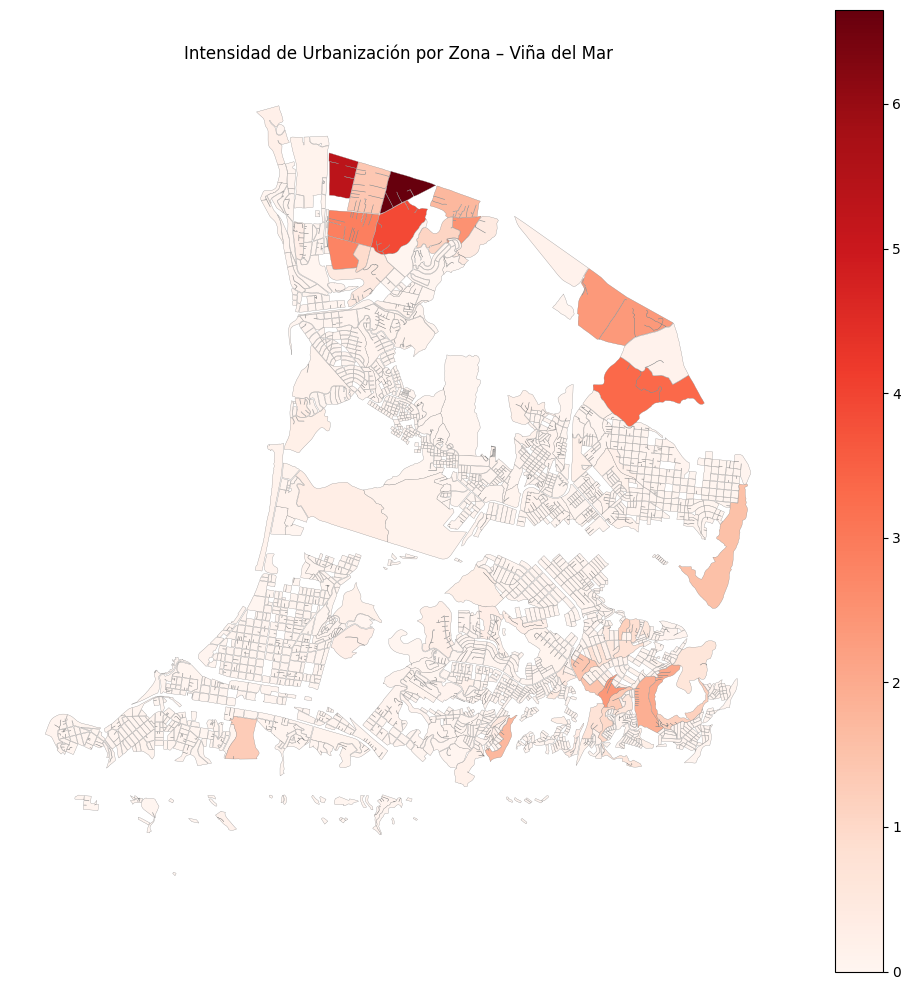

Mapa guardado en:
C:\Users\arace\Documents\GitHub\laboratorio_cambio_urbano\outputs\maps\04_mapa_coropletico_urbanizacion.png


In [6]:
# ==============================================================================
# CELDA 3: MAPA COROPLÉTICO DE CAMBIO URBANO
# ==============================================================================
# Propósito:
#   Visualizar espacialmente la intensidad de urbanización por zona en Viña del Mar,
#   utilizando un mapa coroplético. Este tipo de representación permite identificar
#   patrones espaciales de expansión urbana y comparar la magnitud de los cambios
#   entre distintas unidades territoriales.
#
# Procedimiento:
#   1. Unir resultados tabulares (estadísticas zonales) con geometrías vectoriales.
#   2. Definir la ruta de salida para el mapa.
#   3. Generar un mapa coroplético con la variable "urbanizacion_ha".
#   4. Exportar el mapa como imagen PNG y mostrarlo en pantalla.
# ==============================================================================

# --- Unir resultados tabulares con geometrías ---
zonas_cambio = zonas.merge(
    resultados,
    left_on="MANZENT",   # Identificador de zona en el vector
    right_on="zona"      # Identificador de zona en la tabla de resultados
)

# --- Definir ruta de salida del mapa ---
map_path = output_dirs["maps"] / "04_mapa_coropletico_urbanizacion.png"

# --- Crear figura y ejes ---
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# --- Generar mapa coroplético ---
zonas_cambio.plot(
    column="urbanizacion_ha", # Variable a representar (hectáreas urbanizadas)
    cmap="Reds",              # Escala de colores (rojo = mayor intensidad)
    linewidth=0.2,            # Grosor de bordes
    edgecolor="gray",         # Color de bordes
    legend=True,              # Mostrar leyenda
    ax=ax                     # Dibujar sobre el eje definido
)

# --- Personalizar título y estilo ---
ax.set_title("Intensidad de Urbanización por Zona – Viña del Mar")
ax.axis("off")  # Ocultar ejes cartográficos

# --- Ajustar diseño y guardar mapa ---
plt.tight_layout()
plt.savefig(map_path, dpi=150)
plt.show()

# --- Confirmación de exportación ---
print(f"Mapa guardado en:\n{map_path}")


## Interpretación del mapa de intensidad de urbanización (2019–2025)

El mapa coroplético permite visualizar la distribución espacial del crecimiento urbano en Viña del Mar entre 2019 y 2025, expresado en hectáreas de nueva superficie urbanizada por manzana censal. La escala cromática en tonos rojos muestra un gradiente de intensidad, donde los valores más oscuros representan mayores superficies urbanizadas.

En términos generales, la urbanización no se distribuye de manera homogénea, sino que se concentra en sectores específicos, mientras gran parte de las manzanas presenta cambios nulos o muy bajos. Esto evidencia un proceso de expansión focalizado más que un crecimiento continuo o difuso.

Las zonas con mayor intensidad (tonos rojos oscuros) se ubican principalmente en el norte y nororiente del área urbana, coincidiendo con manzanas que superan las 5 ha de urbanización. Estas áreas funcionan como núcleos activos de expansión, vinculados a nuevos desarrollos habitacionales, cambios de uso de suelo o proyectos inmobiliarios de gran escala.

En contraste, las áreas consolidadas aparecen en tonos claros o blancos, reflejando ausencia de cambios significativos, lo que se asocia a territorios ya densamente urbanizados con limitada disponibilidad de suelo.

También se identifican zonas de intensidad intermedia (rosados y rojos claros), que representan procesos más moderados o fragmentados, como expansiones periféricas, rellenos urbanos o desarrollos menores, actuando como transición entre áreas consolidadas y sectores de mayor expansión.

En conjunto, el mapa confirma los resultados del análisis zonal: el crecimiento urbano en Viña del Mar responde a una lógica concentrada y selectiva. Esta representación visual resulta clave para priorizar áreas de estudio, evaluar impactos ambientales localizados y orientar políticas de gestión del suelo y control de la expansión urbana

nivel_urbanizacion
Sin Cambio    1588
Bajo           276
Medio          136
Name: count, dtype: int64


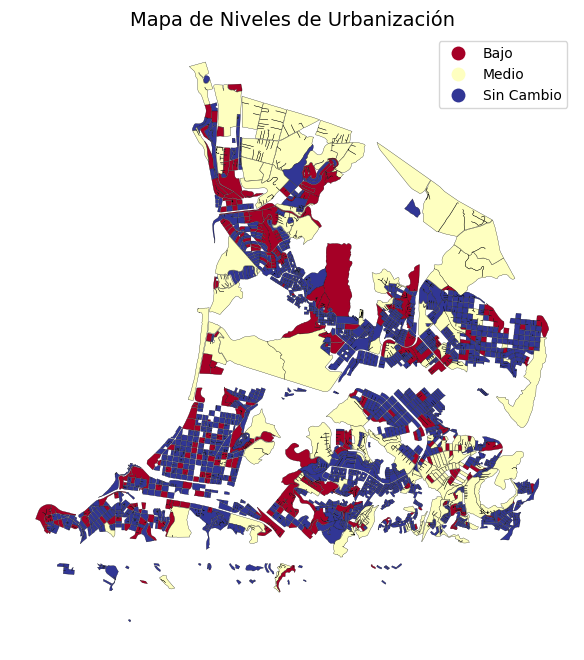

💾 Mapa guardado en: C:\Users\arace\Documents\GitHub\laboratorio_cambio_urbano\outputs\maps\04_nivel_urbanizacion.png


In [7]:
# ==============================================================================
# CELDA 4: ANÁLISIS DE PATRONES ESPACIALES
# ==============================================================================
# Propósito:
#   Clasificar las zonas de estudio según la intensidad de urbanización detectada,
#   utilizando cuantiles para definir categorías relativas ("Bajo", "Medio", "Alto").
#   Esto permite identificar patrones espaciales de expansión urbana y diferenciar
#   áreas con mayor presión de cambio respecto a otras.
#
# Procedimiento:
#   1. Seleccionar valores positivos de urbanización (hectáreas > 0).
#   2. Calcular cuantiles y asignar etiquetas de clasificación.
#   3. Incorporar la clasificación en el GeoDataFrame de zonas.
#   4. Visualizar los resultados en un mapa temático.
# ==============================================================================

# --- Seleccionar valores positivos de urbanización ---
valores_pos = zonas_cambio.loc[zonas_cambio["urbanizacion_ha"] > 0, "urbanizacion_ha"]

# --- Calcular cuantiles con duplicados eliminados ---
cats = pd.qcut(valores_pos, q=3, duplicates="drop")

# --- Generar etiquetas según número de categorías reales ---
labels = ["Bajo", "Medio", "Alto"][:cats.cat.categories.size]

# --- Clasificación de zonas ---
zonas_cambio.loc[zonas_cambio["urbanizacion_ha"] > 0, "nivel_urbanizacion"] = pd.qcut(
    valores_pos,
    q=3,
    labels=labels,
    duplicates="drop"
).astype(str)

# Zonas sin urbanización se etiquetan como "Sin Cambio"
zonas_cambio.loc[zonas_cambio["urbanizacion_ha"] == 0, "nivel_urbanizacion"] = "Sin Cambio"

# --- Ver distribución de categorías ---
print(zonas_cambio["nivel_urbanizacion"].value_counts())

# --- Crear figura y mapa temático ---
fig, ax = plt.subplots(figsize=(8,8))
zonas_cambio.plot(
    column="nivel_urbanizacion", # Variable categórica a representar
    categorical=True,
    legend=True,
    cmap="RdYlBu",               # Paleta de colores divergente
    ax=ax,
    edgecolor="black",
    linewidth=0.2
)
ax.set_title("Mapa de Niveles de Urbanización", fontsize=14)
plt.axis("off")

# --- Definir ruta de salida ---
map_path = output_dirs["maps"] / "04_nivel_urbanizacion.png"

# --- Guardar el mapa ---
plt.savefig(map_path, bbox_inches="tight", dpi=300)
plt.show()
plt.close(fig)

# --- Confirmación de exportación ---
print(f"💾 Mapa guardado en: {map_path}")

## Interpretación del mapa de niveles de urbanización (2019–2025)

El mapa de niveles de urbanización clasifica las manzanas censales de Viña del Mar según la intensidad relativa del cambio urbano, utilizando cuantiles para distinguir tres categorías: Bajo, Medio y Alto, además de una categoría Sin Cambio para aquellas zonas donde no se detectó urbanización durante el período analizado.

En términos generales, el patrón espacial dominante corresponde a la categoría Sin Cambio, representada en color azul, lo que indica que una proporción significativa del tejido urbano no experimentó procesos de expansión superficial entre 2019 y 2025. Estas zonas se concentran principalmente en áreas consolidadas, donde la estructura urbana se encuentra estabilizada y las posibilidades de crecimiento horizontal son limitadas.

Las manzanas clasificadas con nivel Bajo de urbanización (tonos rojizos más intensos) se distribuyen de manera relativamente extendida, actuando como una capa de transición entre las zonas sin cambios y aquellas con mayor intensidad de crecimiento. Este patrón sugiere procesos de urbanización puntuales o de baja magnitud, compatibles con rellenos urbanos, subdivisiones menores o desarrollos de pequeña escala.

Por su parte, eñ nivel Medio (amarillo claro) presenta una distribución espacial más fragmentada y concentrada, formando clústeres bien definidos en sectores específicos del territorio. Estas áreas corresponden a manzanas donde la superficie urbanizada relativa es significativamente mayor en comparación con el resto de las zonas con cambio, y coinciden con los focos de expansión detectados en el análisis cuantitativo previo. En particular, los niveles altos se localizan mayoritariamente en áreas periféricas o de borde urbano, lo que es consistente con procesos de expansión urbana reciente.

La utilización de cuantiles permite destacar la heterogeneidad interna de las zonas con urbanización, evitando que los valores extremos dominen la representación cartográfica. No obstante, esta clasificación debe interpretarse en términos relativos: una manzana clasificada como “Alta” no necesariamente presenta una gran superficie urbanizada en términos absolutos, sino que se encuentra dentro del grupo superior respecto al resto de las manzanas con cambio.

En conjunto, este mapa complementa el mapa coroplético continuo al ofrecer una lectura tipológica del crecimiento urbano, facilitando la identificación de áreas prioritarias para el análisis territorial, la planificación urbana y la evaluación de impactos ambientales localizados. La diferenciación entre zonas sin cambio, cambios de baja intensidad y focos de alta urbanización resulta especialmente útil para orientar estrategias de gestión del suelo y control de la expansión urbana.

📈 Gráfico temporal guardado en:
C:\Users\arace\Documents\GitHub\laboratorio_cambio_urbano\outputs\figures\04_evolucion_temporal_indices.png


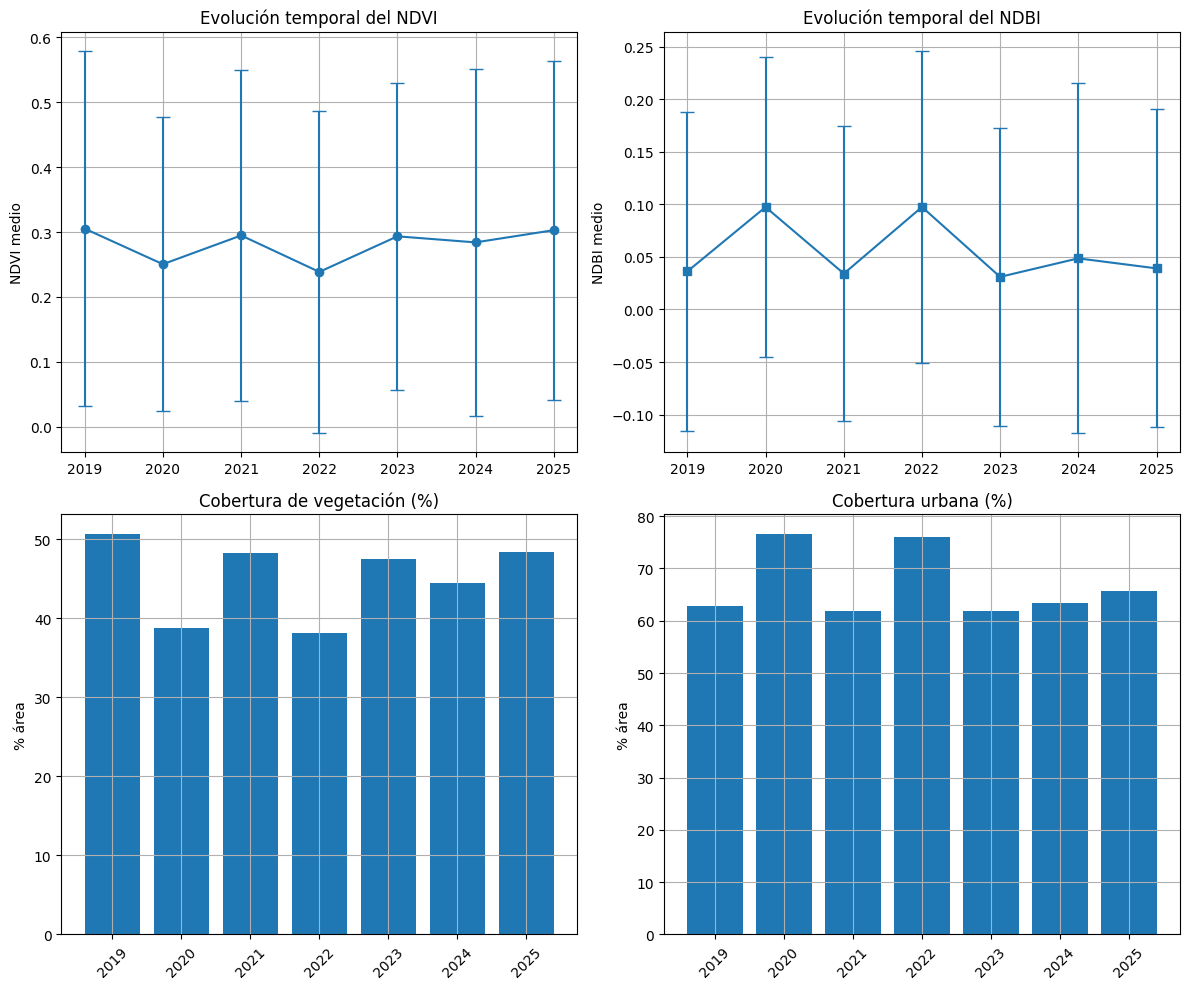

In [8]:
# ==============================================================================
# CELDA 5: ANÁLISIS TEMPORAL DE ÍNDICES ESPECTRALES
# ==============================================================================
# Propósito:
#   Analizar la evolución temporal de índices espectrales (NDVI y NDBI) a partir
#   de una lista de rasters multibanda, evaluando tendencias anuales de vegetación
#   y urbanización en el área de estudio.
#
# Procedimiento:
#   1. Leer rasters multibanda con índices espectrales (NDVI en banda 1, NDBI en banda 2).
#   2. Manejar valores NoData y aplicar máscara espacial si corresponde.
#   3. Calcular estadísticas descriptivas (media, desviación estándar).
#   4. Estimar porcentajes de cobertura de vegetación y urbana.
#   5. Visualizar resultados en gráficos de evolución temporal.
# ==============================================================================

def analisis_temporal(lista_indices, fechas, mascara_area=None):
    """
    Analiza la evolución temporal de índices espectrales (NDVI y NDBI)
    a partir de una lista de rasters multibanda.
    """

    resultados = []

    # --- Iterar sobre rasters y fechas ---
    for ruta, fecha in zip(lista_indices, fechas):
        with rasterio.open(ruta) as src:
            ndvi = src.read(1).astype(float)  # Banda 1: NDVI
            ndbi = src.read(2).astype(float)  # Banda 2: NDBI

            # --- Manejo de NoData ---
            nodata = src.nodata
            if nodata is not None:
                ndvi[ndvi == nodata] = np.nan
                ndbi[ndbi == nodata] = np.nan

        # --- Aplicar máscara espacial si existe ---
        if mascara_area is not None:
            ndvi = ndvi[mascara_area]
            ndbi = ndbi[mascara_area]

        # --- Máscara válida conjunta ---
        mask = ~np.isnan(ndvi) & ~np.isnan(ndbi)
        total_validos = np.sum(mask)

        if total_validos == 0:
            print(f"⚠️ Sin píxeles válidos en {ruta.name}")
            continue

        # --- Calcular estadísticas y métricas ---
        resultados.append({
            "fecha": fecha,
            "ndvi_mean": np.nanmean(ndvi[mask]),
            "ndvi_std":  np.nanstd(ndvi[mask]),
            "ndbi_mean": np.nanmean(ndbi[mask]),
            "ndbi_std":  np.nanstd(ndbi[mask]),
            "pct_vegetacion": 100 * np.sum(ndvi[mask] > 0.3) / total_validos,
            "pct_urbano":     100 * np.sum(ndbi[mask] > 0.0) / total_validos
        })

    # --- Convertir resultados a DataFrame ---
    df = pd.DataFrame(resultados)

    # =====================
    # Visualización
    # =====================
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Evolución temporal del NDVI
    axes[0, 0].errorbar(df["fecha"], df["ndvi_mean"], yerr=df["ndvi_std"],
                        marker="o", capsize=5)
    axes[0, 0].set_title("Evolución temporal del NDVI")
    axes[0, 0].set_ylabel("NDVI medio")

    # Evolución temporal del NDBI
    axes[0, 1].errorbar(df["fecha"], df["ndbi_mean"], yerr=df["ndbi_std"],
                        marker="s", capsize=5)
    axes[0, 1].set_title("Evolución temporal del NDBI")
    axes[0, 1].set_ylabel("NDBI medio")

    x = np.arange(len(df))

    # Cobertura de vegetación
    axes[1, 0].bar(
        x,
        df["pct_vegetacion"]
    )
    axes[1, 0].set_title("Cobertura de vegetación (%)")
    axes[1, 0].set_ylabel("% área")
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(df["fecha"].dt.year, rotation=45)

    # Cobertura urbana
    axes[1, 1].bar(
        x,
        df["pct_urbano"]
    )
    axes[1, 1].set_title("Cobertura urbana (%)")
    axes[1, 1].set_ylabel("% área")
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(df["fecha"].dt.year, rotation=45)

    plt.tight_layout()

    return df


# Ejecución del análisis temporal
# Lista de rasters multibanda con índices espectrales
lista_indices = [
    processed_dir / "indices_2019.tif",
    processed_dir / "indices_2020.tif",
    processed_dir / "indices_2021.tif",
    processed_dir / "indices_2022.tif",
    processed_dir / "indices_2023.tif",
    processed_dir / "indices_2024.tif",
    processed_dir / "indices_2025.tif"
]

# Fechas asociadas a cada raster
fechas = [
    datetime(2019, 1, 1),
    datetime(2020, 1, 1),
    datetime(2021, 1, 1),
    datetime(2022, 1, 1),
    datetime(2023, 1, 1),
    datetime(2024, 1, 1),
    datetime(2025, 1, 1)
]

# Ejecutar análisis temporal
df_temporal = analisis_temporal(lista_indices, fechas)

# Mostrar resultados tabulares
df_temporal

# Guardar resultados gráficos
fig_path = output_dirs["figures"] / "04_evolucion_temporal_indices.png"
plt.savefig(fig_path, dpi=150)

print(f"📈 Gráfico temporal guardado en:\n{fig_path}")

## Interpretación de la evolución temporal de los índices espectrales (2019–2025)

La Figura muestra la evolución temporal de los índices espectrales NDVI y NDBI, junto con la estimación de la cobertura relativa de vegetación y superficie urbana, para el período comprendido entre 2019 y 2025. Este análisis se realizó a partir de rasters multibanda anuales, considerando únicamente los píxeles válidos en cada fecha.

En el panel superior izquierdo se observa la evolución del NDVI medio, el cual presenta valores relativamente estables en torno a 0,25–0,30 a lo largo del período analizado. No obstante, se identifican fluctuaciones interanuales relevantes, con una disminución marcada en 2020 y 2022, seguida de una recuperación progresiva hacia 2023–2025. Esta dinámica sugiere una variabilidad temporal de la cobertura vegetal, posiblemente influenciada tanto por factores climáticos interanuales como por cambios en el uso del suelo. Las barras de error (desviación estándar) evidencian además una alta heterogeneidad espacial del NDVI, consistente con la coexistencia de áreas densamente vegetadas y zonas urbanizadas dentro del área de estudio.

El panel superior derecho muestra la evolución del NDBI medio, indicador asociado a superficies construidas. A diferencia del NDVI, el NDBI presenta valores medios bajos pero positivos, con picos en los años 2020 y 2022. Estos incrementos temporales coinciden con los años donde el NDVI disminuye, lo que refuerza la existencia de una relación inversa entre vegetación y urbanización. La variabilidad reflejada en la desviación estándar indica que el crecimiento urbano no es uniforme, sino que se concentra en sectores específicos del territorio.

Los paneles inferiores complementan esta lectura mediante la estimación de coberturas relativas. La cobertura de vegetación (%) muestra una disminución en 2020 y 2022, seguida de una recuperación parcial en los años posteriores, alcanzando valores cercanos a los observados al inicio del período. Este comportamiento es coherente con la evolución del NDVI medio y sugiere que, pese a la expansión urbana detectada, existen procesos de mantención o recuperación de áreas vegetadas a escala global.

Por su parte, la cobertura urbana (%) presenta valores consistentemente altos, con incrementos notables en 2020 y 2022, lo que coincide con los picos del NDBI medio. Este patrón temporal respalda los resultados del análisis espacial previo, donde se identificaron focos de urbanización concentrados en determinadas zonas, más que un crecimiento homogéneo del tejido urbano.

En conjunto, el análisis temporal de los índices espectrales evidencia una dinámica territorial compleja, en la que la expansión urbana coexiste con fluctuaciones y recuperaciones parciales de la cobertura vegetal. La combinación de NDVI, NDBI y métricas de cobertura permite no solo cuantificar el cambio, sino también interpretar su evolución temporal, aportando una visión complementaria al análisis zonal y cartográfico del crecimiento urbano en el área de estudio.